In [1]:
include("Main_module.jl")
using .TDQMC

In [2]:
using DataFrames, CSV, PyPlot

In [3]:
df = CSV.read("Ground_Guide_Wave.csv", DataFrame)
tr = Matrix(CSV.read("Ground_Trajectory.csv", DataFrame))

2×500 Matrix{Float64}:
  0.0328884  0.195333  -0.657671  …   1.48252    1.4       -0.026361
 -0.587778   1.91626   -0.403192     -0.663044  -0.373878  -1.58648

In [4]:
Electron_num = size(tr, 1)
Ensemble_num = size(tr, 2)
Total_num = Electron_num * Ensemble_num

1000

In [5]:
initial_range = df[:, Total_num+1];         #最后一列保存的是空间的离散信息
Raw_Array = reshape(complex(Matrix(@. abs(parse(Complex{Float64}, df[:, 1:Total_num])))), (3001, Electron_num, Ensemble_num))         # 500代表的是系综*电子数的数目,因为是单电子所以不需要reshape

3001×2×500 Array{ComplexF64, 3}:
[:, :, 1] =
 3.04628e-11+0.0im  1.24819e-10+0.0im
 6.09291e-11+0.0im  2.49651e-10+0.0im
 9.14026e-11+0.0im  3.74509e-10+0.0im
 1.21887e-10+0.0im  4.99407e-10+0.0im
 1.52385e-10+0.0im  6.24359e-10+0.0im
 1.82902e-10+0.0im  7.49378e-10+0.0im
 2.13441e-10+0.0im  8.74477e-10+0.0im
 2.44005e-10+0.0im  9.99672e-10+0.0im
 2.74598e-10+0.0im   1.12498e-9+0.0im
 3.05225e-10+0.0im    1.2504e-9+0.0im
 3.35889e-10+0.0im   1.37597e-9+0.0im
 3.66595e-10+0.0im   1.50169e-9+0.0im
 3.97347e-10+0.0im   1.62758e-9+0.0im
            ⋮       
 3.38167e-10+0.0im   1.49222e-9+0.0im
 3.09841e-10+0.0im   1.36715e-9+0.0im
 2.81555e-10+0.0im   1.24227e-9+0.0im
 2.53302e-10+0.0im   1.11756e-9+0.0im
 2.25081e-10+0.0im  9.93006e-10+0.0im
 1.96887e-10+0.0im  8.68587e-10+0.0im
 1.68717e-10+0.0im  7.44286e-10+0.0im
 1.40567e-10+0.0im  6.20086e-10+0.0im
 1.12433e-10+0.0im  4.95969e-10+0.0im
 8.43133e-11+0.0im  3.71919e-10+0.0im
 5.62033e-11+0.0im  2.47918e-10+0.0im
    2.81e-11+0.0im  1.

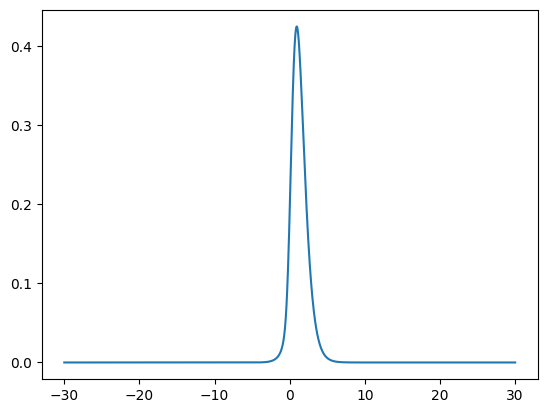

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\86187\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000000D41160>

In [8]:
plot(initial_range, abs2.(Raw_Array[:,1,1]))

In [6]:
s_range = initial_range[end]
s_num = length(initial_range)

3001

In [7]:
l_range = 200.0
l_num = extend_num(s_range, l_range, s_num)

20001

In [8]:
P = Parameter{Float64,Int64}(space_N = l_num, scope = l_range, Δt = 0.05, step_t = 20)

Parameter{Float64, Int64}(2, 500, [1, -1], 20001, 200.0, 0.02, 0.0008, range(-200.0, stop=200.0, length=20001), 0.05, 20)

In [9]:
Raw_GuideWave = stitch_Matrix(Raw_Array, l_num)

2×500 Matrix{Vector{ComplexF64}}:
 [0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]  …  [0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]
 [0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]     [0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]

In [10]:
Raw_GuideWave[1,1]

20001-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [11]:
@timev Dy = Dynamics{Float64,Int64}(Trajectory = deepcopy(tr), Guide_Wave = deepcopy(Raw_GuideWave), Displace = zeros(Float64, (P.step_t + 1, Ensemble_num, Electron_num)),
    Time = zeros(typeof(P.Δt), Ensemble_num))

  1.116605 seconds (364.06 k allocations: 325.388 MiB, 62.00% gc time, 15.26% compilation time)
elapsed time (ns): 1116605100
gc time (ns):      692296400
bytes allocated:   341194506
pool allocs:       362995
non-pool GC allocs:59
malloc() calls:    1002
GC pauses:         1


Dynamics{Float64, Int64}([0.03288844875928036 0.19533294778122012 … 1.400003248802657 -0.026360999224751384; -0.5877776466458721 1.9162616228672578 … -0.3738777157634869 -1.586480950754703], Vector{ComplexF64}[[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im] [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im] … [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0

In [12]:
@timev begin 
    df = nothing
    Raw_DuideWave = nothing
    Raw_Array = nothing
    tr = nothing
    GC.gc()
end

  0.475002 seconds (99.99% gc time)
elapsed time (ns): 475002100
gc time (ns):      474965100
GC pauses:         1
full collections:  1


In [14]:
Dy

Dynamics{Float64, Int64}([0.03288844875928036 0.19533294778122012 … 1.400003248802657 -0.026360999224751384; -0.5877776466458721 1.9162616228672578 … -0.3738777157634869 -1.586480950754703], Vector{ComplexF64}[[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im] [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im] … [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0

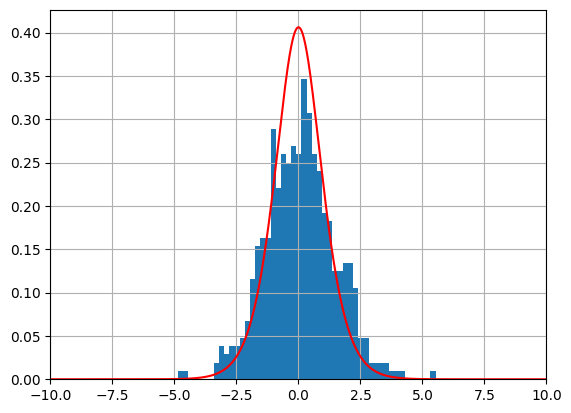

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\86187\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


(-10.0, 10.0)

In [16]:
hist(Dy.Trajectory', 50, density = true);
plot(P.sampling, abs2.(Dy.Guide_Wave[1]), color = "red")      #说明长度能够吻合上
grid()
xlim(-10, 10)

In [15]:
P

Parameter{Float64, Int64}(2, 500, [1, -1], 20001, 200.0, 0.02, 0.0008, range(-200.0, stop=200.0, length=20001), 0.05, 20)

In [13]:
parallel_Evolution!(P, Dy)

[1, 1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1]
[2, 1, 1, 1]
[2, 1, 1, 2]
[2, 2, 1, 2]
[2, 2, 2, 2]
[3, 2, 2, 2]
[3, 2, 2, 3]
[3, 2, 3, 3]
[3, 3, 3, 3]
[3, 3, 3, 4]
[4, 3, 3, 4]
[4, 3, 4, 4]
[4, 4, 4, 4]
[4, 4, 4, 5]
[5, 4, 4, 5]
[5, 5, 4, 5]
[5, 5, 5, 5]
[5, 5, 5, 6]
[6, 5, 5, 6]
[6, 6, 5, 6]
[6, 6, 6, 6]
[7, 6, 6, 6]
[7, 6, 6, 7]
[7, 6, 7, 7]
[7, 7, 7, 7]
[8, 7, 7, 7]
[8, 7, 7, 8]
[8, 7, 8, 8]
[8, 8, 8, 8]
[9, 8, 8, 8]
[9, 8, 8, 9]
[9, 8, 9, 9]
[9, 9, 9, 9]
[10, 9, 9, 9]
[10, 9, 9, 10]
[10, 9, 10, 10]
[10, 10, 10, 10]
[11, 10, 10, 10]
[11, 10, 10, 11]
[11, 10, 11, 11]
[11, 11, 11, 11]
[12, 11, 11, 11]
[12, 11, 11, 12]
[12, 12, 11, 12]
[12, 12, 12, 12]
[13, 12, 12, 12]
[13, 12, 12, 13]
[13, 12, 13, 13]
[13, 13, 13, 13]
[14, 13, 13, 13]
[14, 13, 13, 14]
[14, 14, 13, 14]
[14, 14, 14, 14]
[15, 14, 14, 14]
[15, 14, 14, 15]
[15, 15, 14, 15]
[15, 15, 15, 15]
[16, 15, 15, 15]
[16, 15, 15, 16]
[16, 16, 15, 16]
[16, 16, 16, 16]
[17, 16, 16, 16]
[17, 16, 16, 17]
[17, 17, 16, 17]
[17, 17, 17

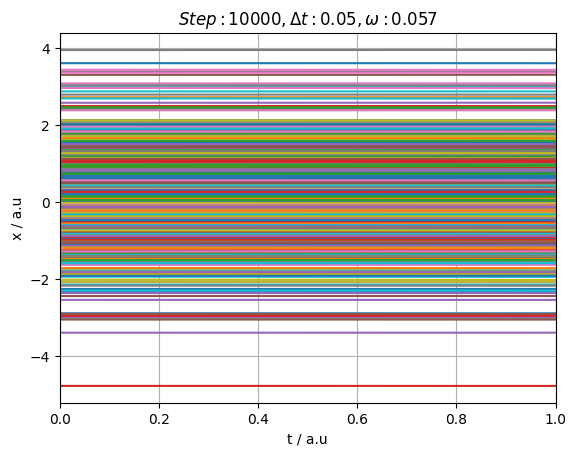

PyObject Text(0.5, 1.0, '$Step:10000,\\Delta t:0.05,\\omega:0.057$')

In [16]:
plot(real(P.Δt).* (0:20), Dy.Displace[:, :, 2])
#ylim(-200.0, 200.0)
xlim(0, P.Δt * 20)
xlabel("t / a.u")
ylabel("x / a.u")
grid()
title(L"Step:10000,\Delta t:0.05,\omega:0.057")